#### Analysis of PCA of several animals

In [1]:
cd ../utilities/

/home/gustav/Documents/DD142X/code/utilities


In [2]:
from features import ffv
from matlab_util import str_lfp, gp_lfp
from plotting import rasterize

In [3]:
cd ../_data/matlabData

/home/gustav/Documents/DD142X/code/_data/matlabData


In [4]:
files = !ls
print(files)

['NPR-075.b11.mat', 'NPR-075.b13.mat', 'NPR-075.c013.mat', 'NPR-075.c08.mat', 'NPR-075.d07.mat', 'NPR-076.b05.mat', 'NPR-076.b09.mat', 'NPR-076.c09.mat', 'NPR-076.d07.mat']


In [5]:
import numpy as np
import matplotlib.pyplot as plt

ep = 2 ** 11
print("Epoch length: " + str(1000 * ep / 16000) + "ms")

str_epochs = np.concatenate([
    str_lfp(filename, ep).reshape((-1, ep)) for filename in files
], axis = 0)

gp_epochs = np.concatenate([
    gp_lfp(filename, ep).reshape((-1, ep)) for filename in files
], axis = 0)

print(str_epochs.shape)
print(gp_epochs.shape)

Epoch length: 128.0ms
(65872, 2048)
(97678, 2048)


In [8]:
strides = 10
lo = 10
hi = 45
fft_n = 2 ** 13


incr_str = int(str_epochs.shape[0] / strides)
strs = [
    ffv(
        str_epochs[i * incr_str : (i + 1) * incr_str],
        epoch_size = ep,
        lo = lo,
        hi = hi,
        fft_n = fft_n
    ) for i in range(0, strides)
]

incr_gp = int(gp_epochs.shape[0] / strides)
gps = [
    ffv(
        gp_epochs[i * incr_gp : (i + 1) * incr_gp],
        epoch_size = ep,
        lo = lo,
        hi = hi,
        fft_n = fft_n
    ) for i in range(0, strides)
]

In [9]:
frqs = strs[0][1]
print(frqs)

[11.71875  13.671875 15.625    17.578125 19.53125  21.484375 23.4375
 25.390625 27.34375  29.296875 31.25     33.203125 35.15625  37.109375
 39.0625   41.015625 42.96875  44.921875]


In [10]:
strs = [str_ for str_, _ in strs]
gps = [ gp_ for gp_, _ in gps]

In [11]:
strs = np.array(strs)
gps = np.array(gps)
features = strs.shape[2]

In [12]:
strs = strs.reshape((-1, features))
gps = gps.reshape((-1, features))
print(strs.shape)
print(gps.shape)

(65870, 18)
(97670, 18)


In [13]:
from sklearn.decomposition import PCA

all_lfp = np.concatenate((strs, gps), axis = 0)
print(all_lfp.shape)

(163540, 18)


In [14]:
pca = PCA(n_components = 10).fit(all_lfp.copy())

In [15]:
pca_all = pca.transform(all_lfp.copy())
pca_str = pca.transform(strs.copy())
pca_gp  = pca.transform(gps.copy())

print(pca_all.shape)
print(pca_str.shape)
print(pca_gp.shape)

(163540, 10)
(65870, 10)
(97670, 10)


PCA n = 163540


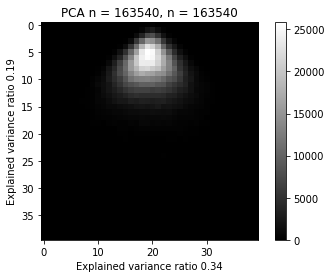

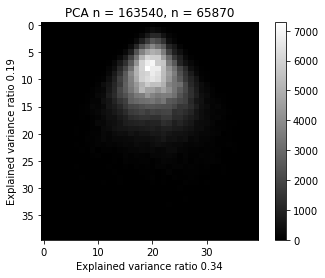

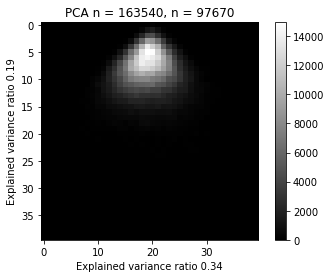

In [16]:
print("PCA n = " + str(pca_all.shape[0]))
x1var, x2var = pca.explained_variance_ratio_[0:2]
x1var = round(x1var, 2)
x2var = round(x2var, 2)

raster_all = rasterize(pca_all)
plt.imshow(raster_all, cmap = 'gray', vmin = np.min(raster_all), vmax = np.max(raster_all))
plt.title("PCA n = " + str(pca_all.shape[0]) + ", n = " + str(pca_all.shape[0]))
plt.xlabel("Explained variance ratio " + str(x1var))
plt.ylabel("Explained variance ratio " + str(x2var))
plt.colorbar()
plt.show()

raster_str = rasterize(pca_str)
plt.imshow(raster_str, cmap = 'gray', vmin = np.min(raster_str), vmax = np.max(raster_str))
plt.title("PCA n = " + str(pca_all.shape[0]) + ", n = " + str(pca_str.shape[0]))
plt.xlabel("Explained variance ratio " + str(x1var))
plt.ylabel("Explained variance ratio " + str(x2var))
plt.colorbar()
plt.show()

raster_gp = rasterize(pca_gp)
plt.imshow(raster_gp, cmap = 'gray', vmin = np.min(raster_gp), vmax = np.max(raster_gp))
plt.title("PCA n = " + str(pca_all.shape[0]) + ", n = " + str(pca_gp.shape[0]))
plt.xlabel("Explained variance ratio " + str(x1var))
plt.ylabel("Explained variance ratio " + str(x2var))
plt.colorbar()
plt.show()

In [18]:
print(pca.explained_variance_ratio_.sum())
for ratio, component in zip(pca.explained_variance_ratio_, pca.components_):
    print("Explained variance ratio: " + str(ratio))
    print(component)

0.9869634961341543
Explained variance ratio: 0.33853401860881954
[0.39212593 0.39401825 0.36134882 0.4022094  0.40447235 0.33199875
 0.21685454 0.15107723 0.11991238 0.0968328  0.07283884 0.07614492
 0.0775653  0.06466004 0.04655164 0.05260338 0.05548948 0.0435956 ]
Explained variance ratio: 0.18786153984965928
[ 0.48754878  0.48027475  0.19459046 -0.13952614 -0.36993521 -0.43237002
 -0.344503   -0.1707158  -0.036513   -0.00185845 -0.01375279 -0.00098093
  0.01846692  0.01900809  0.00638057  0.00833747  0.01424236  0.01162344]
Explained variance ratio: 0.1349676650606849
[ 0.34411304  0.01290947 -0.40453292 -0.45360127 -0.19417197  0.10843329
  0.31709991  0.3912658   0.31563567  0.1958373   0.12840862  0.13368216
  0.12248813  0.08161508  0.05096519  0.06500495  0.07230124  0.05351637]
Explained variance ratio: 0.08559713603424826
[-0.38529064 -0.06896713  0.25769548  0.17757928 -0.11869246 -0.27867685
 -0.16895884  0.10796095  0.34784766  0.42158925  0.36607469  0.28291591
  0.214637

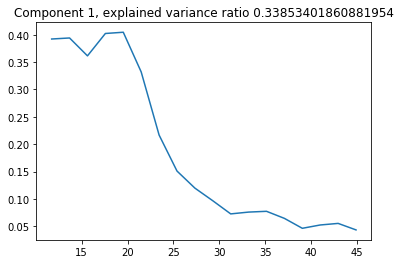

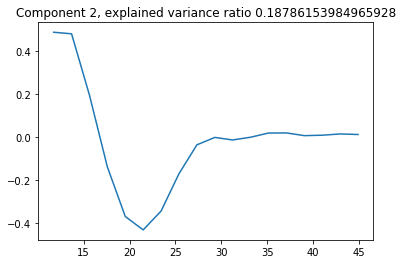

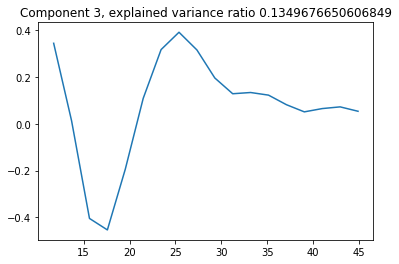

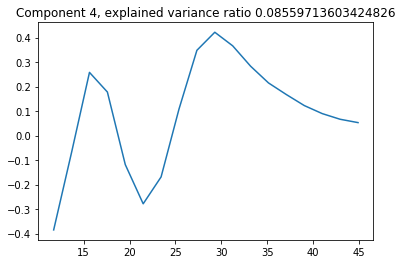

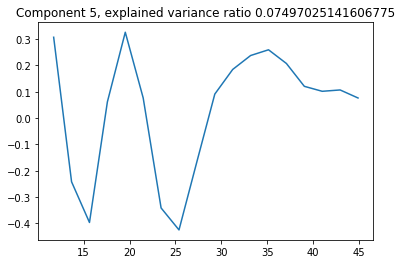

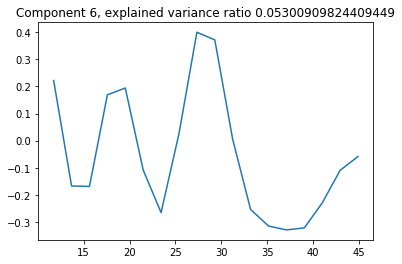

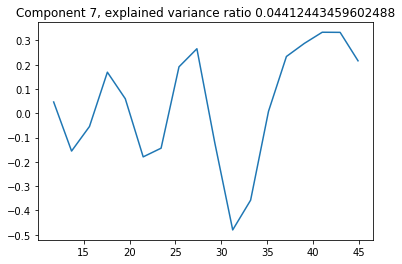

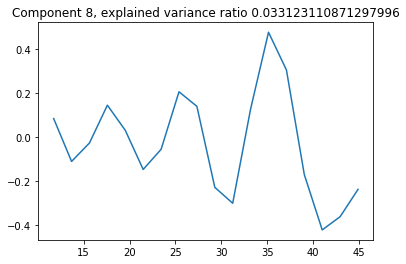

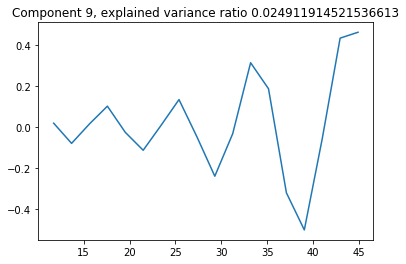

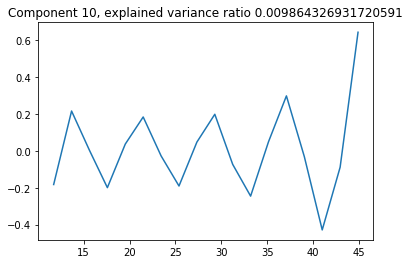

In [20]:
for idx, (ratio, component) in enumerate(zip(pca.explained_variance_ratio_, pca.components_)):
    plt.clf()
    plt.title("Component " + str(idx + 1) + ", explained variance ratio " + str(ratio))
    plt.plot(frqs, component)
    plt.show()

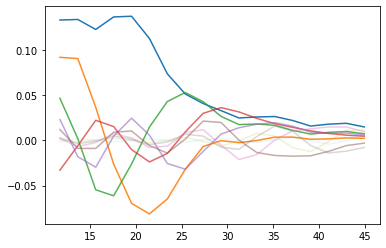

In [22]:
plt.clf()
for idx, (ratio, component) in enumerate(zip(pca.explained_variance_ratio_, pca.components_)):
    plt.plot(frqs, ratio * component, alpha = 1 - idx/10)
plt.show()